In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import datetime as dt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

In [3]:
data = pd.read_csv('/content/drive/MyDrive/Crypto/test_2/BinanceCoin/BNB-USD.csv', date_parser = True)
data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-30,16.263498,16.370699,15.539147,15.715951,15.715951,213428131
1,2019-12-01,15.743181,15.743181,15.054234,15.496336,15.496336,203268417
2,2019-12-02,15.509364,15.707174,15.152545,15.191858,15.191858,200809249
3,2019-12-03,15.191858,15.553175,15.048669,15.309556,15.309556,219927266
4,2019-12-04,15.348430,15.690587,15.009685,15.279978,15.279978,237605471
...,...,...,...,...,...,...,...
1092,2022-11-26,300.571747,316.962128,300.389465,311.388458,311.388458,1221554861
1093,2022-11-27,311.372040,316.219879,307.156372,307.429291,307.429291,793779029
1094,2022-11-28,307.399567,309.096100,289.493683,293.527252,293.527252,1154829072
1095,2022-11-29,293.491821,304.822815,289.763641,295.498169,295.498169,986451640


# **Data Pre-processing**

In [4]:
#Replace None or Null values with forward filling technique using fillna function.

data = data.fillna(method = 'ffill')

In [5]:
#Convert Date column into Datatime format

data['Date'] = pd.to_datetime(data.Date)

# **Data Visualization**

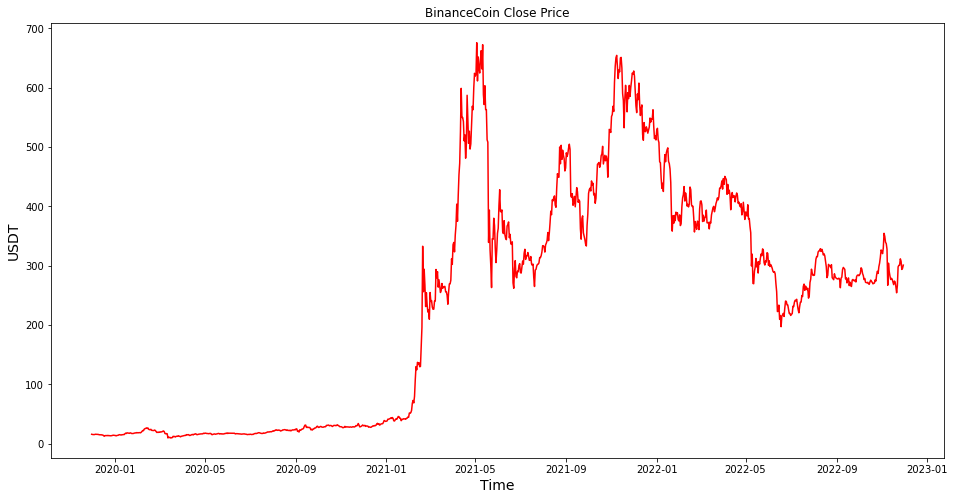

In [6]:
# Visualize the close price history
plt.figure(figsize=(16, 8))
plt.plot(data['Date'], data['Close'], color="red")
plt.title('BinanceCoin Close Price')
plt.xlabel("Time", fontsize=14,)
plt.ylabel("USDT", fontsize=14)
plt.show()

# **Data Spliting**

In [7]:
data_training = data[data['Date']< '2022-03-30'].copy()
data_training

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-11-30,16.263498,16.370699,15.539147,15.715951,15.715951,213428131
1,2019-12-01,15.743181,15.743181,15.054234,15.496336,15.496336,203268417
2,2019-12-02,15.509364,15.707174,15.152545,15.191858,15.191858,200809249
3,2019-12-03,15.191858,15.553175,15.048669,15.309556,15.309556,219927266
4,2019-12-04,15.348430,15.690587,15.009685,15.279978,15.279978,237605471
...,...,...,...,...,...,...,...
846,2022-03-25,414.148254,421.153717,406.296051,410.811157,410.811157,1678265707
847,2022-03-26,410.816254,416.317535,407.981262,415.919800,415.919800,1082240527
848,2022-03-27,415.931366,431.025574,412.382904,430.503265,430.503265,1499505093
849,2022-03-28,430.546814,440.728394,428.565216,430.390869,430.390869,2128699500


In [8]:
data_test = data[data['Date']> '2022-03-30'].copy()
data_test

,Date,Open,High,Low,Close,Adj Close,Volume
852,2022-03-31,442.658875,451.961090,424.950287,428.916107,428.916107,2632534284
853,2022-04-01,429.124023,446.796539,414.749390,446.604279,446.604279,2718206274
854,2022-04-02,446.844208,453.558472,436.776703,436.955353,436.955353,2272901729
855,2022-04-03,436.865814,455.228455,432.821716,450.348877,450.348877,2128734028
856,2022-04-04,450.264557,450.432617,434.178009,447.524933,447.524933,2248856403
...,...,...,...,...,...,...,...
1092,2022-11-26,300.571747,316.962128,300.389465,311.388458,311.388458,1221554861
1093,2022-11-27,311.372040,316.219879,307.156372,307.429291,307.429291,793779029
1094,2022-11-28,307.399567,309.096100,289.493683,293.527252,293.527252,1154829072
1095,2022-11-29,293.491821,304.822815,289.763641,295.498169,295.498169,986451640


# **Feature Engineering**

In [9]:
#feature selection
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)
training_data.head()

,Open,High,Low,Close,Volume
0,16.263498,16.370699,15.539147,15.715951,213428131
1,15.743181,15.743181,15.054234,15.496336,203268417
2,15.509364,15.707174,15.152545,15.191858,200809249
3,15.191858,15.553175,15.048669,15.309556,219927266
4,15.348430,15.690587,15.009685,15.279978,237605471


In [10]:
#Normalizing training_data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
training_data

array([[0.01034271, 0.00901231, 0.01366467, 0.0095001 , 0.00430502],
       [0.00956257, 0.00809043, 0.012892  , 0.0091705 , 0.00373573],
       [0.00921199, 0.00803753, 0.01304865, 0.00871353, 0.00359794],
       ...,
       [0.60958939, 0.61817549, 0.64599823, 0.6320253 , 0.0763689 ],
       [0.63150323, 0.63242976, 0.67178323, 0.63185661, 0.11162511],
       [0.63079565, 0.63357439, 0.67418876, 0.63803224, 0.10372414]])

In [11]:
#Prepare train data
X_train = []
Y_train = []

In [12]:
training_data.shape[0]

851

In [13]:
for i in range(60, training_data.shape[0]):
    X_train.append(training_data[i-60:i])
    Y_train.append(training_data[i,0])

In [14]:
X_train, Y_train = np.array(X_train), np.array(Y_train)
X_train.shape

(791, 60, 5)

# Model Building

In [15]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], 5)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 59, 64)            704       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 29, 64)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense (Dense)               (None, 50)                92850     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 93,605
Trainable params: 93,605
Non-trainable params: 0
____________________________________________________

In [16]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(X_train, Y_train, epochs = 50, batch_size =32)

Epoch 1/50
25/25 [==============================] - 2s 10ms/step - loss: 0.0499
Epoch 2/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0061
Epoch 3/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0035
Epoch 4/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0025
Epoch 5/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 6/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0020
Epoch 7/50
25/25 [==============================] - 0s 12ms/step - loss: 0.0019
Epoch 8/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0018
Epoch 9/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0015
Epoch 10/50
25/25 [==============================] - 0s 11ms/step - loss: 0.0016
Epoch 11/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0016
Epoch 12/50
25/25 [==============================] - 0s 10ms/step - loss: 0.0013
Epoch 13/50
25/25 [==================

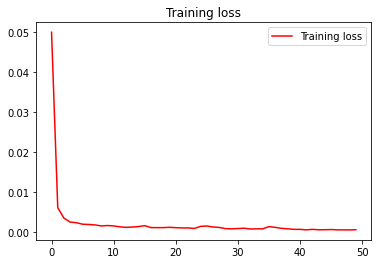

<Figure size 432x288 with 0 Axes>

In [17]:
loss = history.history['loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.figure()

plt.show()

# **Performance Evaluation**

In [18]:
past_60_days = data_training.tail(60)
df= past_60_days.append(data_test, ignore_index = True)
df = df.drop(['Date', 'Adj Close'], axis = 1)
df.head()

,Open,High,Low,Close,Volume
0,386.065735,396.772278,381.683777,389.132782,1330610935
1,389.202209,389.247192,373.036285,377.612915,1289330238
2,377.648987,384.977386,366.112030,375.277313,1386778184
3,375.099182,387.767548,374.326843,385.463806,1392647608
4,385.488770,386.114716,366.895386,367.471680,1290849744


In [19]:
inputs = scaler.transform(df)
inputs

array([[0.56481001, 0.56785449, 0.59708203, 0.56993524, 0.06690511],
       [0.56951272, 0.5567995 , 0.58330305, 0.55264588, 0.06459199],
       [0.55219026, 0.5505268 , 0.5722699 , 0.54914054, 0.07005238],
       ...,
       [0.44686097, 0.43905075, 0.4501857 , 0.42644761, 0.05705537],
       [0.42600823, 0.43277293, 0.45061585, 0.42940562, 0.04762053],
       [0.42909151, 0.43252048, 0.4579752 , 0.43735427, 0.04891876]])

In [20]:
X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    Y_test.append(inputs[i, 0])

In [21]:
X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test.shape, Y_test.shape

((245, 60, 5), (245,))

In [22]:
Y_pred = model.predict(X_test)

8/8 [==============================] - 0s 8ms/step


In [23]:
print("RMSE: ", math.sqrt(mean_squared_error(Y_test,Y_pred)))
print("MSE: ", mean_squared_error(Y_test,Y_pred))
print("MAE: ", mean_absolute_error(Y_test,Y_pred))
print("R2 score:", r2_score(Y_test, Y_pred))

RMSE:  0.030037261866026496
MSE:  0.0009022371004082495
MAE:  0.02273846212389438
R2 score: 0.8737678119297135


In [24]:
scaler.scale_

array([1.49936165e-03, 1.46908483e-03, 1.59340684e-03, 1.50082989e-03,
       5.60338796e-11])

In [25]:
scale = 1/5.18164146e-05
scale

19298.903787912797

In [26]:
Y_test = Y_test*scale
Y_pred = Y_pred*scale

In [27]:
# Y_test = scaler.inverse_transform(Y_test)
# Y_pred = scaler.inverse_transform(Y_pred) 

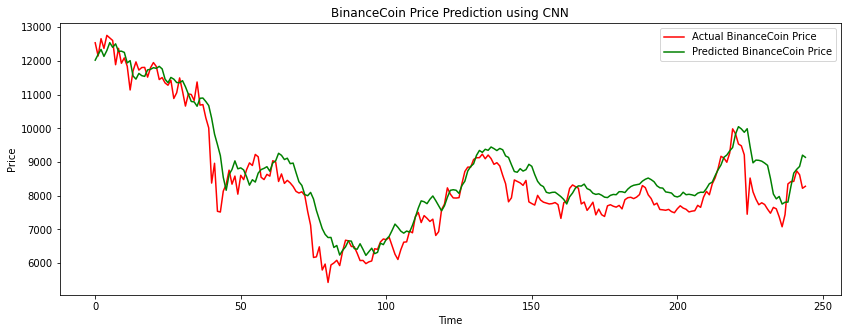

In [28]:
plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Actual BinanceCoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted BinanceCoin Price')
plt.title('BinanceCoin Price Prediction using CNN')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()